data leakage을 주의할것


# 0. 라이브러리 설정 및 데이터 로드

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

from lightgbm import LGBMClassifier

import os
os.chdir('./data')

In [128]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

In [129]:
train = train.drop(['index','FLAG_MOBIL'], axis = 1)
test = test.drop(['index','FLAG_MOBIL'], axis = 1)

In [130]:
print(train.shape, test.shape)
train.head() 

(26457, 18) (10000, 17)


,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,0,0,0,Managers,2.0,-26.0,2.0


1. income_total(소득) <> child_num, family_size = 소득대비 부양 ratio  // 2개 
2. DAYS_BIRTH(나이) <> income_total(소득) = 나이대비 소득 // 1개
3. DAYS_EMPLOYED(근속년수) <> income_total(소득) = 근속년수대비 소득 // 1개
4. DAYS_EMPLOYED(근속년수) <> DAYS_BIRTH(나이) = 근속년수대비 나이 
5. begin_month(발급월수) <> income_total, DAYS_BIRTH, DAYS_EMPLOYED = 발급월수 대비 소득,근속년수, 나이 // 3개

In [131]:
object_column = train.dtypes[train.dtypes == 'object'].index.tolist()
train[object_column] # 카테고리형 변수

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type
0,F,N,N,Commercial associate,Higher education,Married,Municipal apartment,NaN
1,F,N,Y,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,Laborers
2,M,Y,Y,Working,Higher education,Married,House / apartment,Managers
3,F,N,Y,Commercial associate,Secondary / secondary special,Married,House / apartment,Sales staff
4,F,Y,Y,State servant,Higher education,Married,House / apartment,Managers
...,...,...,...,...,...,...,...,...
26452,F,N,N,State servant,Secondary / secondary special,Married,House / apartment,Core staff
26453,F,N,Y,Working,Higher education,Separated,House / apartment,NaN
26454,F,Y,N,Working,Secondary / secondary special,Civil marriage,With parents,Core staff
26455,M,N,Y,Working,Incomplete higher,Single / not married,House / apartment,Laborers


occyp_type가 결측값인데, 이를 예측해보자.

In [132]:
train.describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.428658,1.873065e+05,-15958.053899,59068.750728,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,0.747326,1.018784e+05,4201.589022,137475.427503,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,0.000000,1.215000e+05,-19431.000000,-3153.000000,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,0.000000,1.575000e+05,-15547.000000,-1539.000000,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,1.000000,2.250000e+05,-12446.000000,-407.000000,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,19.000000,1.575000e+06,-7705.000000,365243.000000,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [133]:
train[train['child_num'] == 19]

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,credit
10731,F,N,Y,19,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-11057,-1853,1,1,0,Waiters/barmen staff,20.0,-5.0,2.0


In [134]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  object 
 1   car            26457 non-null  object 
 2   reality        26457 non-null  object 
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  work_phone     26457 non-null  int64  
 12  phone          26457 non-null  int64  
 13  email          26457 non-null  int64  
 14  occyp_type     18286 non-null  object 
 15  family_size    26457 non-null  float64
 16  begin_month    26457 non-null  float64
 17  credit         26457 non-null  float64
dtypes: flo

In [135]:
train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [136]:
train.shape, test.shape

((26457, 18), (10000, 17))

데이터에 대한 결측치도 확인하였음.

In [137]:
processing_data = train.copy()

# 1) 탐색적 데이터 분석

## 1.1 타겟 값 분포

In [138]:
fot_eda_train = train
fot_eda_train.shape

(26457, 18)

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64

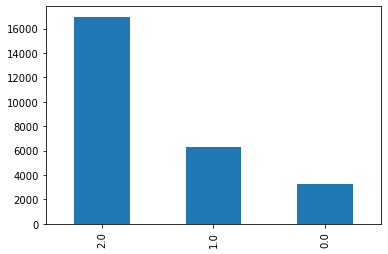

In [139]:
fot_eda_train['credit'].value_counts(sort=True).plot.bar()
fot_eda_train['credit'].value_counts(sort=True) # 개수

 Target 데이터에 대한 불균형이 존재한다. 따라서 SMOTE 샘플링이 필요한 것으로 보임.

In [140]:
for column in object_column:
    print("===================" + column + "===================")
    print(train[column].unique())
    # print(column + "의 Feature 유형 확인 : " + train[column].unique())

===================gender===================
['F' 'M']
===================car===================
['N' 'Y']
===================reality===================
['N' 'Y']
===================income_type===================
['Commercial associate' 'Working' 'State servant' 'Pensioner' 'Student']
===================edu_type===================
['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
===================family_type===================
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
===================house_type===================
['Municipal apartment' 'House / apartment' 'With parents'
 'Co-op apartment' 'Rented apartment' 'Office apartment']
===================occyp_type===================
[nan 'Laborers' 'Managers' 'Sales staff' 'High skill tech staff'
 'Core staff' 'Drivers' 'Medicine staff' 'Accountants' 'Realty agents'
 'Security staff' 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Secretar

## 1.2 타겟값에 따른 피쳐(연속형, 카테고리형) 분포도

In [141]:
num_columns = train.dtypes[train.dtypes != 'object'].index.tolist()
object_columns = train.dtypes[train.dtypes == 'object'].index.tolist()

In [80]:
# 타겟값에 따른 피쳐(연속형) 분포도
def show_hist_by_target(df, columns):
    cond_2 = (df['credit'] == 2)
    cond_1 = (df['credit'] == 1)
    cond_0 = (df['credit'] == 0)
    
    for column in columns:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), squeeze=False)
        sns.violinplot(x='credit', y=column, data=df, ax=axs[0][0] )

        sns.distplot(df[cond_0][column], ax=axs[0][1], label='0', color='black')
        sns.distplot(df[cond_1][column], ax=axs[0][1], label='1', color='blue')
        sns.distplot(df[cond_2][column], ax=axs[0][1], label='2', color='red')
        
# 타겟값에 따른 피쳐(카테고리형) 분포도         
def show_category_by_target(df, columns):
    for column in columns:
        print("column name : ", column)
        chart = sns.catplot(x = column, col = 'credit', data = df, kind = 'count')
        chart.set_xticklabels(rotation = 45) # x축을 회전 
        

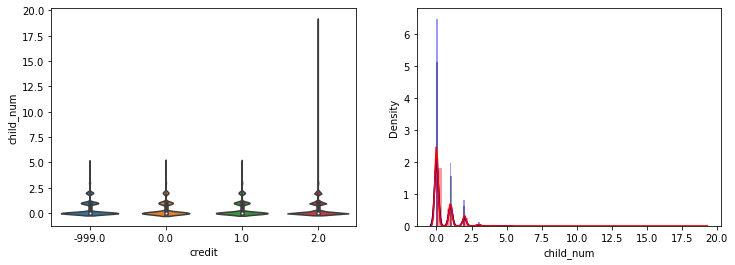

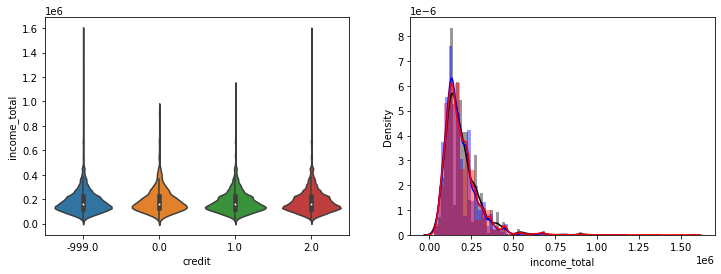

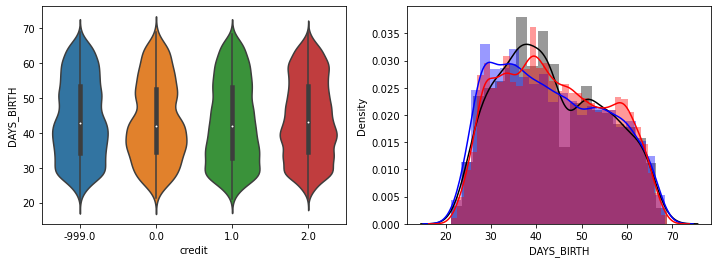

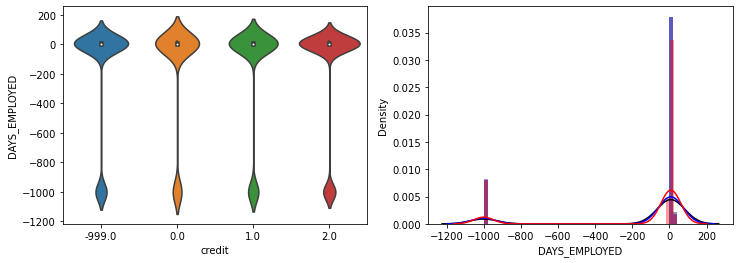

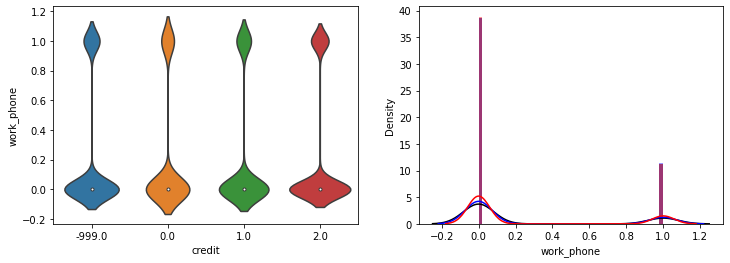

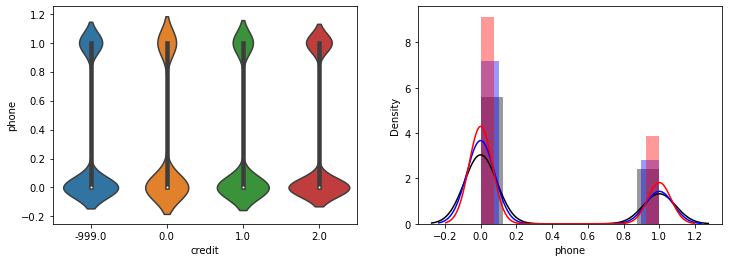

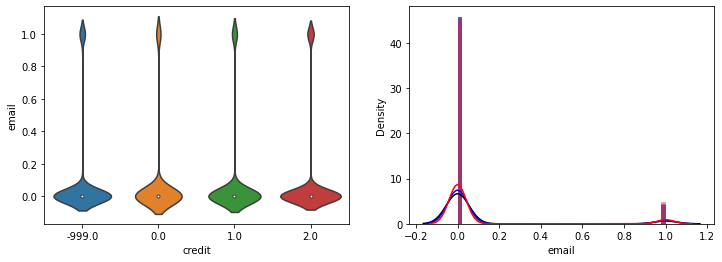

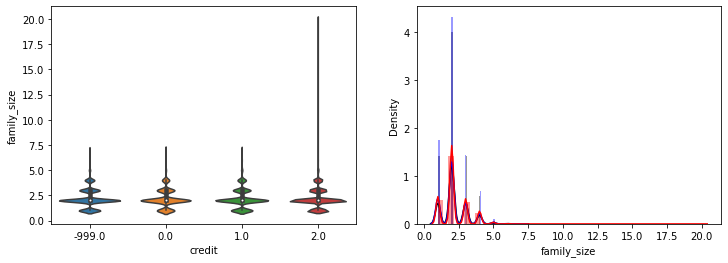

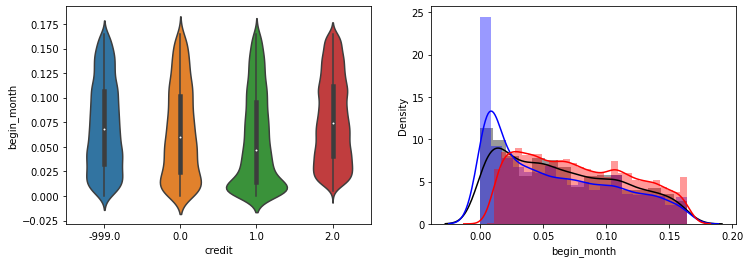

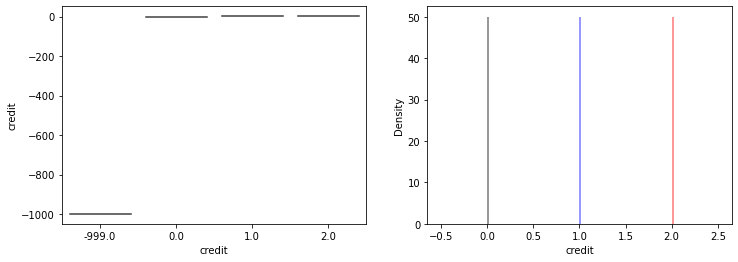

In [264]:
show_hist_by_target(merge_data, num_columns)

column name :  gender
column name :  car
column name :  reality
column name :  income_type
column name :  edu_type
column name :  family_type
column name :  house_type
column name :  occyp_type


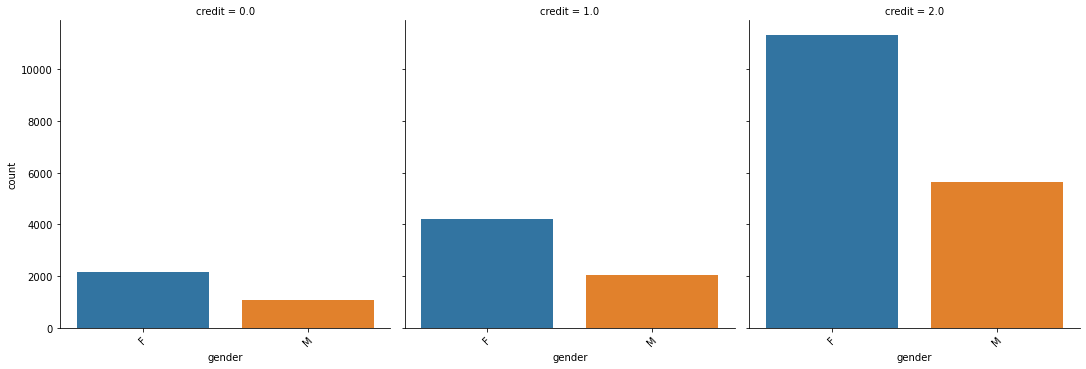

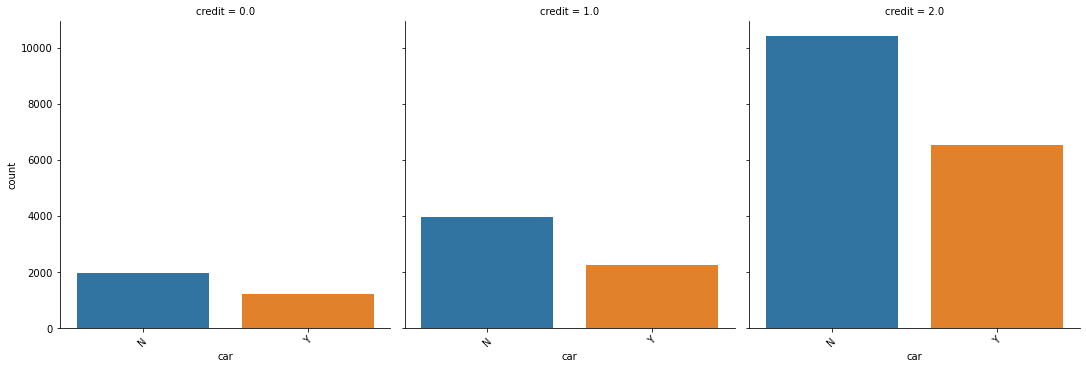

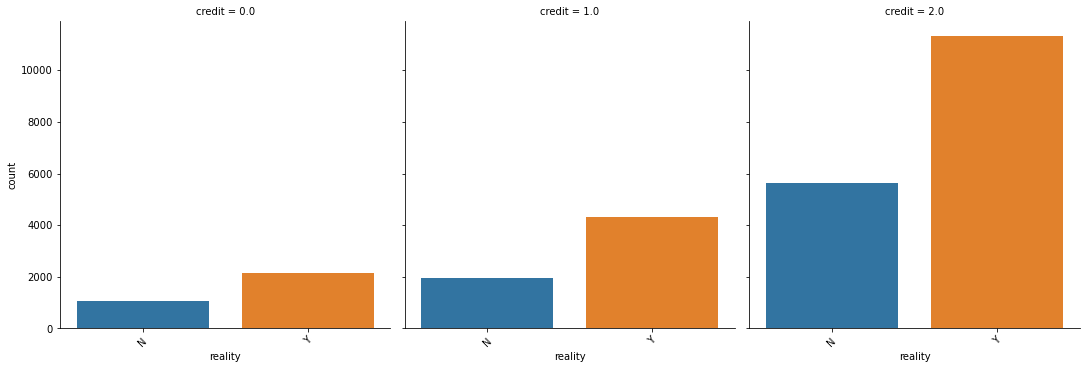

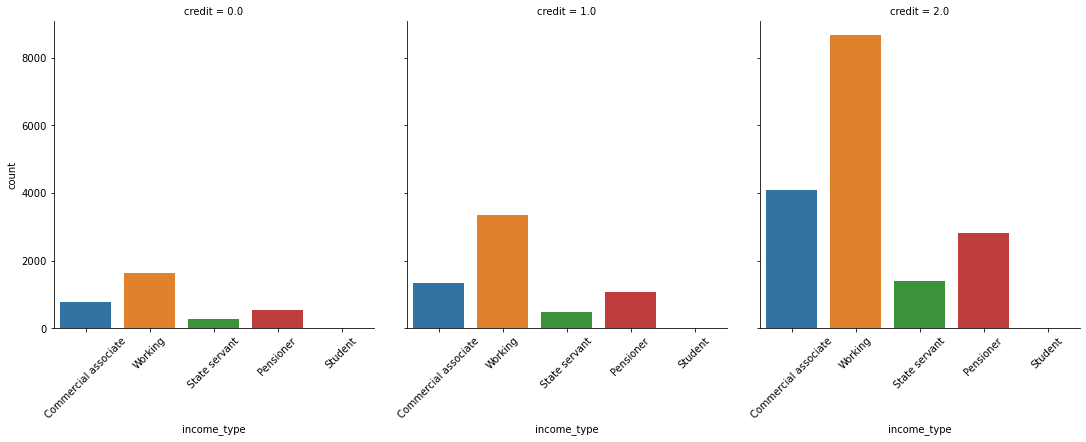

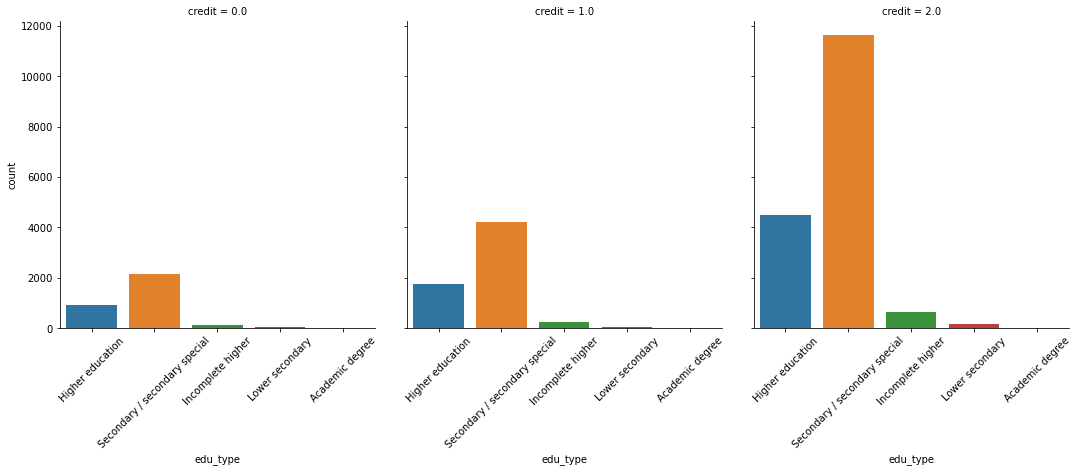

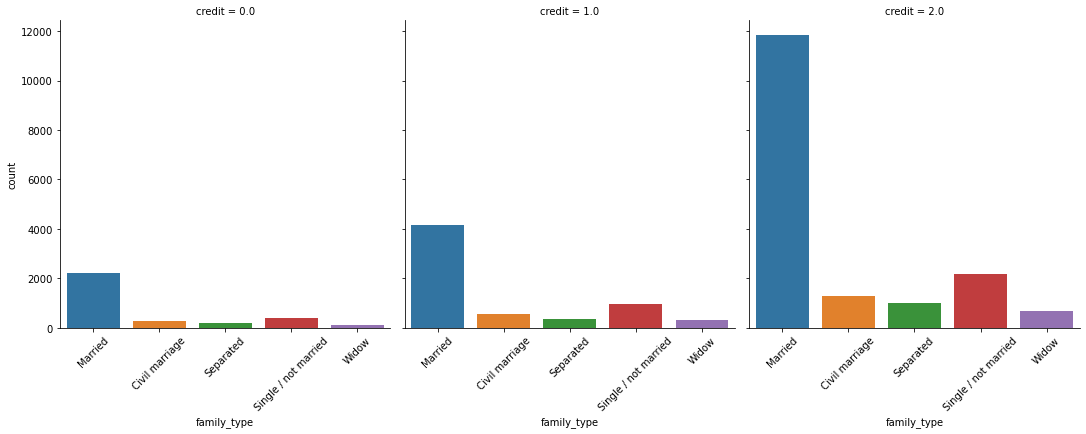

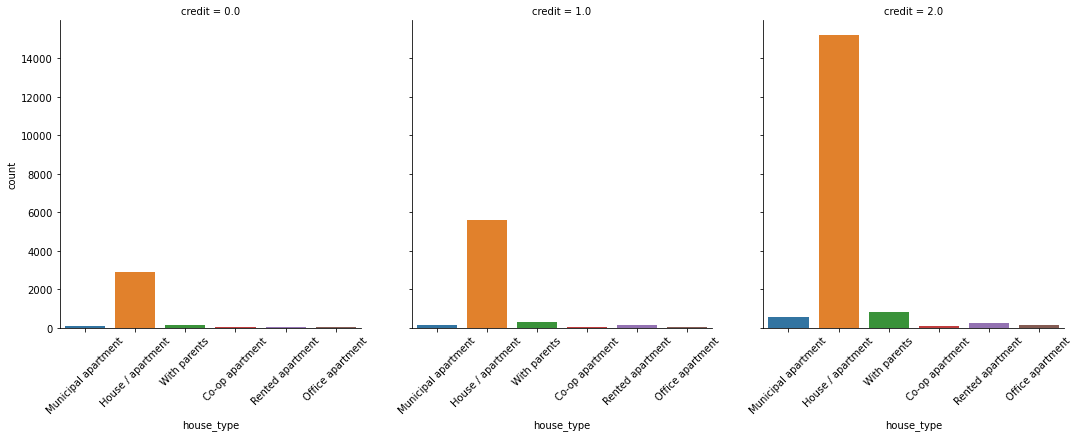

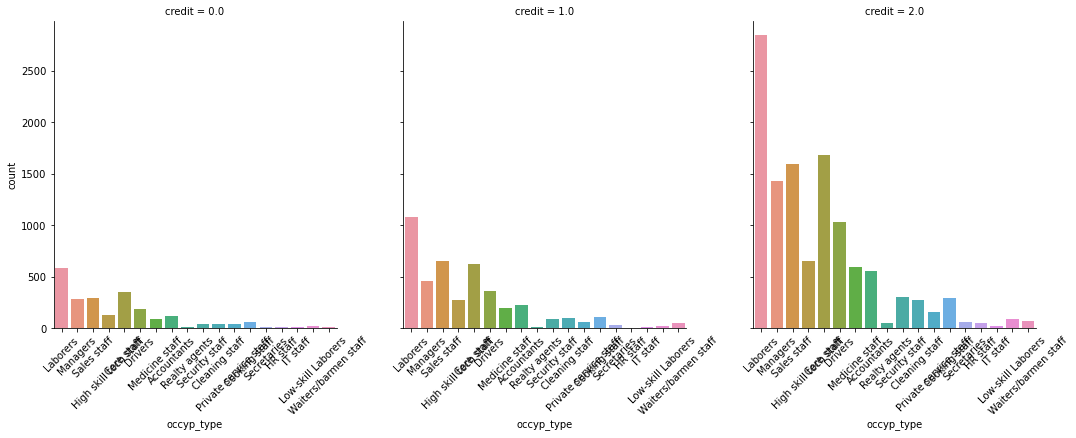

In [82]:
show_category_by_target(fot_eda_train, object_columns)

## 1.3 상관도 및 Heatmap

In [83]:
corr = fot_eda_train[fot_eda_train.columns.tolist()].corr()
corr

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit
child_num,1.000000,0.032186,0.332816,-0.228159,0.051521,-0.010555,0.016120,0.890530,-0.007229,0.004081
income_total,0.032186,1.000000,0.064155,-0.166478,-0.034207,0.019013,0.089882,0.023839,-0.018047,0.008555
DAYS_BIRTH,0.332816,0.064155,1.000000,-0.616776,0.178752,-0.029247,0.111238,0.298108,0.057306,-0.025187
DAYS_EMPLOYED,-0.228159,-0.166478,-0.616776,1.000000,-0.241827,-0.007749,-0.091090,-0.223077,0.007964,-0.003798
work_phone,0.051521,-0.034207,0.178752,-0.241827,1.000000,0.310256,-0.031048,0.068705,-0.008563,-0.003134
phone,-0.010555,0.019013,-0.029247,-0.007749,0.310256,1.000000,0.012494,-0.000132,-0.014286,0.003452
email,0.016120,0.089882,0.111238,-0.091090,-0.031048,0.012494,1.000000,0.016122,0.002320,0.014812
family_size,0.890530,0.023839,0.298108,-0.223077,0.068705,-0.000132,0.016122,1.000000,-0.023032,0.008227
begin_month,-0.007229,-0.018047,0.057306,0.007964,-0.008563,-0.014286,0.002320,-0.023032,1.000000,-0.147477
credit,0.004081,0.008555,-0.025187,-0.003798,-0.003134,0.003452,0.014812,0.008227,-0.147477,1.000000


<AxesSubplot:>

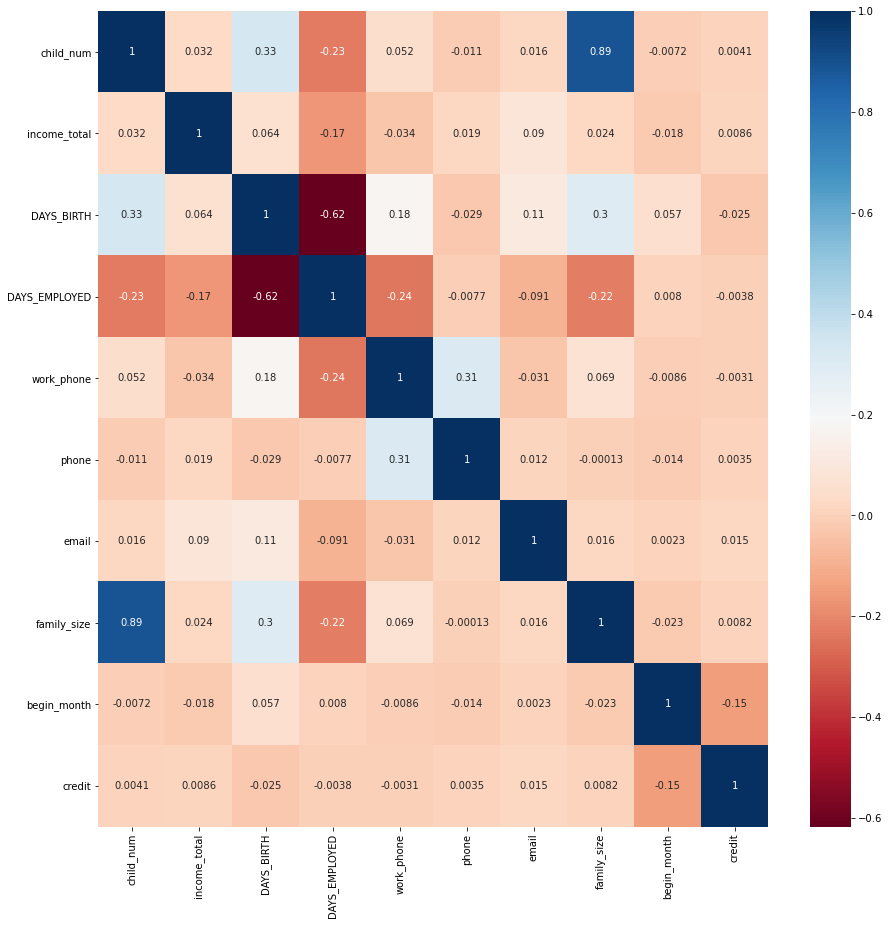

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize =(15,15))
sns.heatmap(corr,cmap='RdBu', annot = True)

family_size와 child_num의 상관관계가 높다. 나이와 근속연수의 상관관계가 높다.

각 피쳐들에 대한 탐색적 데이터 분석을 진행했고, 이에 대한 해석이 필요하다. 거기서 타겟값에 따른 피쳐들의 분포를 통해 이상치를 파악하거나, 인사이트를 도출해야함. 상관도 분석을 하였음

# =========================================================

# 2. 데이터 전처리 & 피쳐 엔지니어링

## 1. 결측치 변경

#### occyp_type 결측치 처리

In [112]:
# 다중 로지스틱 회귀로 occyp_type를 예측하여 넣기

train.groupby('occyp_type')['income_total'].mean()

# 분포 확인
NA_train = train[train['occyp_type'].isnull()]
NA_train['credit'].value_counts()

# credit 제거
temp_train = train.drop('credit', axis = 1, inplace = False)
temp_train.head()
print("백업")

백업


In [142]:
train.groupby('occyp_type')['income_total'].mean().sort_values(ascending = False)

occyp_type
Managers                 278735.249654
Realty agents            246357.142857
Drivers                  210853.714286
Accountants              204651.942905
Private service staff    198018.518519
IT staff                 196770.731707
High skill tech staff    196602.403846
Core staff               191473.629252
HR staff                 186387.096774
Laborers                 180307.189827
Security staff           180252.594340
Sales staff              174955.579756
Medicine staff           167212.364583
Secretaries              163716.494845
Waiters/barmen staff     159822.580645
Cleaning staff           148209.677419
Cooking staff            146275.601751
Low-skill Laborers       135708.661417
Name: income_total, dtype: float64

In [143]:
NA_train['income_total'].describe() # 가장 근사한 Cooking staff 로 변경!

count      8171.000000
mean     169174.356444
std       94186.305218
min       29250.000000
25%      112500.000000
50%      144000.000000
75%      202500.000000
max      900000.000000
Name: income_total, dtype: float64

In [108]:
train.shape, test.shape

((26457, 18), (10000, 17))

In [144]:
pr_train = train
pr_test = test

In [145]:
train.isnull().sum() , test.isnull().sum()

In [54]:
train['occyp_type'].value_counts() # 일단 가장 많은 Laborers로 대체한다.

Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

In [146]:
train['occyp_type'] = train['occyp_type'].fillna('Cooking staff')
test['occyp_type'] = test['occyp_type'].fillna('Cooking staff')

#### 파생변수 ratio 만들기

In [216]:
# 소득
merge_data = pd.concat([train, test], axis = 0)
print(merge_data.shape)

merge_data['DAYS_BIRTH'] = merge_data['DAYS_BIRTH'] / -365
merge_data['DAYS_EMPLOYED'] = merge_data['DAYS_EMPLOYED'] / -365
merge_data['begin_month'] = merge_data['begin_month'] / -365

merge_data['new_1'] = merge_data['child_num'] / merge_data['income_total']
merge_data['new_2'] = merge_data['family_size'] / merge_data['income_total']
merge_data['new_3'] = merge_data['DAYS_BIRTH'] / merge_data['income_total']
merge_data['new_4'] = merge_data['DAYS_EMPLOYED'] / merge_data['income_total']
merge_data['new_5'] = merge_data['begin_month'] / merge_data['income_total']

merge_data['new_6'] =  merge_data['DAYS_EMPLOYED'] / merge_data['DAYS_BIRTH']
merge_data['new_7'] =  merge_data['begin_month'] / merge_data['DAYS_BIRTH']
merge_data['new_8'] =  merge_data['begin_month'] / merge_data['DAYS_EMPLOYED']

In [ ]:
merge_data['credit'].value_counts(dropna=False)

In [217]:
merge_data.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,begin_month,credit,new_1,new_2,new_3,new_4,new_5,new_6,new_7,new_8
0,0,0,0,0,202500.0,0,0,0,0,38.079452,...,0.016438,1.0,0.000000,0.000010,0.000188,0.000064,8.117707e-08,0.338801,0.000432,0.001274
1,0,0,1,1,247500.0,0,1,1,1,31.178082,...,0.013699,1.0,0.000004,0.000012,0.000126,0.000017,5.534800e-08,0.135325,0.000439,0.003247
2,1,1,1,0,450000.0,1,0,0,1,52.293151,...,0.060274,2.0,0.000000,0.000004,0.000116,0.000027,1.339422e-07,0.232305,0.001153,0.004962
3,0,0,1,0,202500.0,0,1,0,1,41.336986,...,0.101370,0.0,0.000000,0.000010,0.000204,0.000028,5.005919e-07,0.138653,0.002452,0.017686
4,0,1,1,0,157500.0,2,0,0,1,41.197260,...,0.071233,2.0,0.000000,0.000013,0.000262,0.000037,4.522722e-07,0.139988,0.001729,0.012352


#### 카테고리형 레이블 인코딩

In [243]:
object_columns = merge_data.dtypes[merge_data.dtypes == 'object'].index.tolist()

for column in object_columns:
    merge_data[column] = pd.factorize(merge_data[column])[0]
    
merge_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         36457 non-null  int64  
 1   car            36457 non-null  int64  
 2   reality        36457 non-null  int64  
 3   child_num      36457 non-null  int64  
 4   income_total   36457 non-null  float64
 5   income_type    36457 non-null  int64  
 6   edu_type       36457 non-null  int64  
 7   family_type    36457 non-null  int64  
 8   house_type     36457 non-null  int64  
 9   DAYS_BIRTH     36457 non-null  float64
 10  DAYS_EMPLOYED  36457 non-null  float64
 11  work_phone     36457 non-null  int64  
 12  phone          36457 non-null  int64  
 13  email          36457 non-null  int64  
 14  occyp_type     36457 non-null  int64  
 15  family_size    36457 non-null  float64
 16  begin_month    36457 non-null  float64
 17  credit         36457 non-null  float64
 18  new_1  

train과 test를 병합하여 한번에 전처리 할 것 -> data leakage 위험, 따로 한다!

In [244]:
merge_data['credit'].value_counts(dropna = False)

 2.0      16968
-999.0    10000
 1.0       6267
 0.0       3222
Name: credit, dtype: int64

In [245]:
merge_data = merge_data.fillna(-999)

new_train = merge_data[merge_data['credit'] != -999]
new_test = merge_data[merge_data['credit'] == -999]

new_train.shape , new_test.shape

((26457, 26), (10000, 26))

In [247]:
new_train.head(10)

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,...,begin_month,credit,new_1,new_2,new_3,new_4,new_5,new_6,new_7,new_8
0,0,0,0,0,202500.0,0,0,0,0,38.079452,...,0.016438,1.0,0.000000,0.000010,0.000188,0.000064,8.117707e-08,0.338801,0.000432,0.001274
1,0,0,1,1,247500.0,0,1,1,1,31.178082,...,0.013699,1.0,0.000004,0.000012,0.000126,0.000017,5.534800e-08,0.135325,0.000439,0.003247
2,1,1,1,0,450000.0,1,0,0,1,52.293151,...,0.060274,2.0,0.000000,0.000004,0.000116,0.000027,1.339422e-07,0.232305,0.001153,0.004962
3,0,0,1,0,202500.0,0,1,0,1,41.336986,...,0.101370,0.0,0.000000,0.000010,0.000204,0.000028,5.005919e-07,0.138653,0.002452,0.017686
4,0,1,1,0,157500.0,2,0,0,1,41.197260,...,0.071233,2.0,0.000000,0.000013,0.000262,0.000037,4.522722e-07,0.139988,0.001729,0.012352
5,0,0,1,2,270000.0,1,1,0,1,36.747945,...,0.049315,1.0,0.000007,0.000015,0.000136,0.000051,1.826484e-07,0.372474,0.001342,0.003603
6,0,0,0,0,315000.0,1,1,2,1,48.136986,...,0.112329,2.0,0.000000,0.000003,0.000153,0.000017,3.565993e-07,0.112578,0.002334,0.020728
7,1,0,1,0,270000.0,0,1,0,1,40.810959,...,0.145205,0.0,0.000000,0.000007,0.000151,0.000055,5.377981e-07,0.363856,0.003558,0.009779
8,1,1,1,1,180000.0,0,0,0,1,41.454795,...,0.104110,2.0,0.000006,0.000017,0.000230,0.000022,5.783866e-07,0.096887,0.002511,0.025921
9,0,0,1,0,103500.0,1,1,0,1,43.246575,...,0.013699,2.0,0.000000,0.000019,0.000418,0.000035,1.323539e-07,0.082863,0.000317,0.003823


# 코드공유

In [248]:
new_train.shape , new_test.shape

((26457, 26), (10000, 26))

#### 원핫인코딩

In [222]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(new_train.loc[:,object_column])

# train
train_onehot_df = pd.DataFrame(enc.transform(new_train.loc[:,object_column]).toarray(), 
             columns=enc.get_feature_names(object_column))
new_train.drop(object_column, axis=1, inplace=True)
new_train = pd.concat([new_train, train_onehot_df], axis=1)

# test
test_onehot_df = pd.DataFrame(enc.transform(new_test.loc[:,object_column]).toarray(), 
             columns=enc.get_feature_names(object_column))
new_test.drop(object_column, axis=1, inplace=True)
new_test = pd.concat([new_test, test_onehot_df], axis=1)

# 위에서 이미 지움
# new_train.drop('index', axis=1, inplace=True)
# new_test.drop('index', axis=1, inplace=True)

#### 샘플링 SMOTE

In [250]:
train_x= new_train.drop('credit', axis=1, inplace = False)
train_y= new_train['credit']
test_x = new_test
test_x.shape

(10000, 26)

In [251]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
train_x_over,train_y_over = smote.fit_sample(train_x,train_y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', train_x.shape, train_y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', train_x_over.shape, train_y_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(train_y_over).value_counts())

train_x = train_x_over
train_y = train_y_over

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (26457, 25) (26457,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (50904, 25) (50904,)
SMOTE 적용 후 레이블 값 분포: 
 0.0    16968
2.0    16968
1.0    16968
Name: credit, dtype: int64


In [252]:
new_train_SMOTE = train_x
new_train_SMOTE['credit'] = train_y

In [253]:
new_train_SMOTE.shape

(50904, 26)

#### 모델

In [256]:
train = new_train_SMOTE

In [258]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(new_train_SMOTE, new_train_SMOTE['credit']):
    folds.append((train_idx, valid_idx))

In [259]:
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000)
    
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 30 rounds
[100]	training's multi_logloss: 0.660992	valid_1's multi_logloss: 0.714336
[200]	training's multi_logloss: 0.550583	valid_1's multi_logloss: 0.642012
[300]	training's multi_logloss: 0.471149	valid_1's multi_logloss: 0.594079
[400]	training's multi_logloss: 0.414118	valid_1's multi_logloss: 0.564325
[500]	training's multi_logloss: 0.367631	valid_1's multi_logloss: 0.543505
[600]	training's multi_logloss: 0.329233	valid_1's multi_logloss: 0.528307
[700]	training's multi_logloss: 0.297983	valid_1's multi_logloss: 0.518888
[800]	training's multi_logloss: 0.269205	valid_1's multi_logloss: 0.510545
[900]	training's multi_logloss: 0.2441	valid_1's multi_logloss: 0.503862
[1000]	training's multi_logloss: 0.222107	valid_1's multi_logloss: 0.499277
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.222107	valid_1's multi_lo

In [228]:
train = new_train
test = new_test

In [233]:
test.drop('credit', axis=1, inplace=True)

In [235]:
submission.iloc[:,1:]=0
for fold in range(5):
    submission.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

In [237]:
submission.to_csv('5_submission.csv', index=False) # 0.7272812144

# Log-loss 출력

In [195]:
# 샘플링


from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)
train_x_over,train_y_over = smote.fit_sample(train_x,train_y)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', train_x.shape, train_y.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', train_x_over.shape, train_y_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(train_y_over).value_counts())

train_x = train_x_over
train_y = train_y_over
print(train_x.shape, train_y.shape)

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (26457, 62) (26457,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (50904, 62) (50904,)
SMOTE 적용 후 레이블 값 분포: 
 0.0    16968
2.0    16968
1.0    16968
Name: credit, dtype: int64


In [232]:
test['credit']

0      -999.0
1      -999.0
2      -999.0
3      -999.0
4      -999.0
        ...  
9995   -999.0
9996   -999.0
9997   -999.0
9998   -999.0
9999   -999.0
Name: credit, Length: 10000, dtype: float64

In [238]:
train_x= new_train.drop('credit', axis=1, inplace = False)
train_y= new_train['credit']
test_x = new_test

test_x.shape

(10000, 62)

In [188]:
new_train.head()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,credit,...,occyp_type_8,occyp_type_9,occyp_type_10,occyp_type_11,occyp_type_12,occyp_type_13,occyp_type_14,occyp_type_15,occyp_type_16,occyp_type_17
0,0,202500.0,-13899,-4709,0,0,0,2.0,-6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,247500.0,-11380,-1540,0,0,1,3.0,-5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,450000.0,-19087,-4434,0,1,0,2.0,-22.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,202500.0,-15088,-2092,0,1,0,2.0,-37.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,157500.0,-15037,-2105,0,0,0,2.0,-26.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [260]:
train = new_train_SMOTE.drop('credit', axis=1, inplace = False)
target = new_train_SMOTE['credit']

In [261]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_val, y_train, y_val = train_test_split(train, target, 
                                                    stratify=target, test_size=0.25,
                                                    random_state = 10086)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Validation set: ")
print(X_val.shape)
print(y_val.shape)


clf=LGBMClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_val)
print(f"log_loss: {log_loss(to_categorical(y_val), y_pred)}")

Train set: 
(38178, 25)
(38178,)
Validation set: 
(12726, 25)
(12726,)
log_loss: 0.7110448796509907


In [262]:
from sklearn.model_selection import KFold, StratifiedKFold

def run_kfold(clf):
    folds=StratifiedKFold(n_splits=5, shuffle=True, random_state=55)
    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))  
    
    for n_fold, (train_index, val_index) in enumerate(folds.split(train_x, train_y)):
        X_train, X_val = train_x.iloc[train_index], train_x.iloc[val_index]
        y_train, y_val = train_y.iloc[train_index], train_y.iloc[val_index]
        clf.fit(X_train, y_train)
        
        predictions=clf.predict_proba(X_val)
        
        logloss=log_loss(to_categorical(y_val), predictions)
        outcomes.append(logloss)
        print(f"FOLD {n_fold} : logloss:{logloss}")
        
        sub+=clf.predict_proba(test_x)
        
    mean_outcome=np.mean(outcomes)
    
    print("Mean:{}".format(mean_outcome))
    return sub/folds.n_splits

my_submission = run_kfold(clf) # 1차 0.75924 # 4/30 -> 0.7516 # 샘플링 적용후 0.6812(원핫) <> 

FOLD 0 : logloss:1.2856576998567819e-06
FOLD 1 : logloss:1.2856576872543875e-06
FOLD 2 : logloss:1.2856577172481682e-06
FOLD 3 : logloss:1.285657711791831e-06
FOLD 4 : logloss:1.2856577450394046e-06
Mean:1.2856577122381145e-06


### 변수 중요도

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

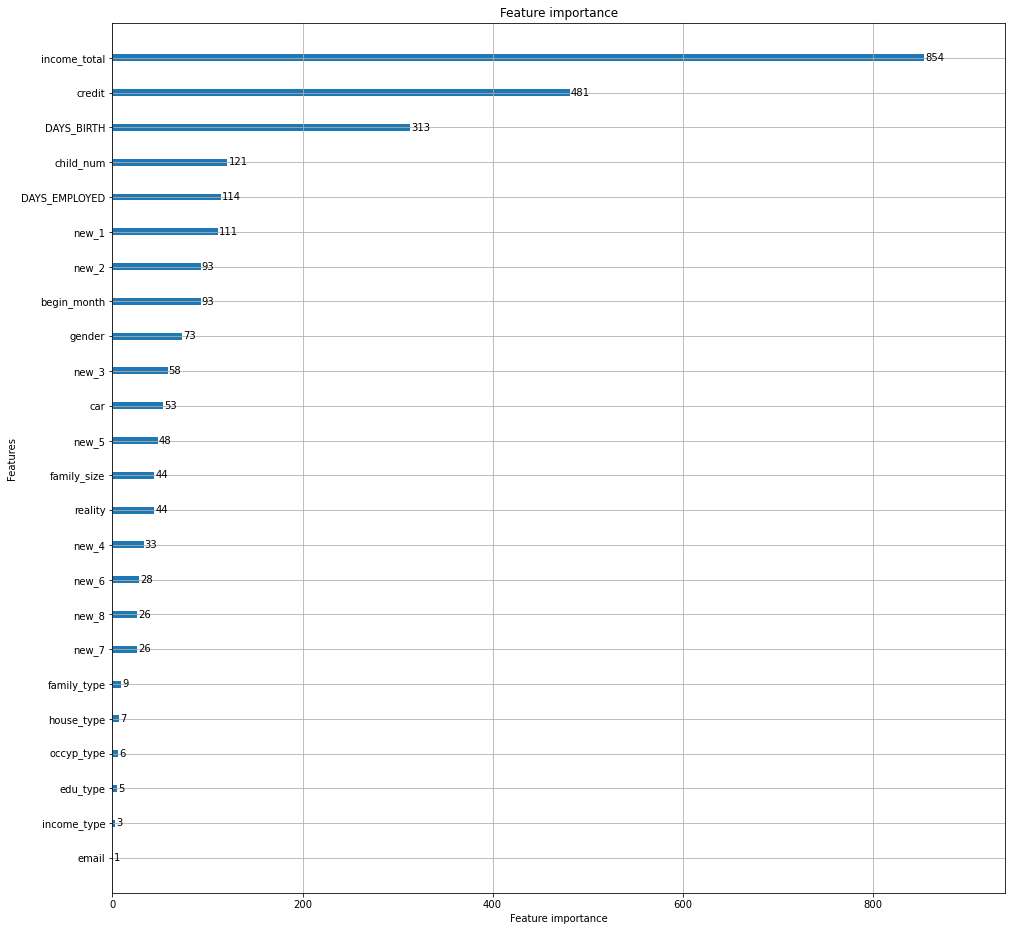

In [263]:
from lightgbm import plot_importance

plot_importance(clf, figsize=(16, 16))

# Fianl submission

In [198]:
submission.loc[:,1:] = my_submission
submission.head()

,index,0,1,2
0,26457,0.112045,0.145455,0.742500
1,26458,0.241824,0.251357,0.506819
2,26459,0.224606,0.130885,0.644509
3,26460,0.279818,0.176341,0.543842
4,26461,0.099836,0.182353,0.717811


In [199]:
submission.to_csv('5_submission.csv', index = False)

In [196]:
train_x = train_x_over
train_y = train_y_over
train_x.shape, train_y.shape

((50904, 62), (50904,))

In [186]:
new_test['credit']

KeyError: 'credit'